<a href="https://colab.research.google.com/github/marvinmouroum/cv-heart-rate-measurement/blob/master/cv_heart_rate_measurement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face detection

In [0]:
import os
import cv2
import numpy as np
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
from googleapiclient.http import MediaIoBaseDownload
from google.colab import drive as gdrive

In [2]:
gdrive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Project/'
source_path = 'gdrive/My Drive/cohface/'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
!ls gdrive/My\ Drive/Project

deploy.prototxt.txt  weights.caffemodel


In [0]:
# Define paths
prototxt_path = os.path.join(root_path + 'deploy.prototxt')
caffemodel_path = os.path.join(root_path + 'weights.caffemodel')

prototxt_path_id = '1-zfDOBY5fVcEzwii2JlrIDFyhLyvu5m5'
caffemodel_path_id = '1jxuFoSukXr78rLfBgkLwn2qiWNUfoONf'
image_id = '1wb8whYMorQNU2YvmHZsZGFeUTDc-95DN'

downloaded = drive.CreateFile({'id': prototxt_path_id})
downloaded.GetContentFile('deploy.prototxt')

downloaded = drive.CreateFile({'id': caffemodel_path_id})
downloaded.GetContentFile('weights.caffemodel')

downloaded = drive.CreateFile({'id': image_id})
downloaded.GetContentFile('images/image.jpg')

# Read the model
model = cv2.dnn.readNetFromCaffe(prototxt_path, caffemodel_path)

In [15]:
# Create directory 'updated_images' if it does not exist
if not os.path.exists('updated_images'):
	print("New directory created")
	os.makedirs('updated_images')

New directory created


In [16]:
# Create directory 'faces' if it does not exist
if not os.path.exists('faces'):
	print("New directory created")
	os.makedirs('faces')

New directory created


In [28]:
!ls images

image.jpg


In [32]:
# Loop through all images and save images with marked faces
for file in os.listdir('images'):
	file_name, file_extension = os.path.splitext(file)
	if (file_extension in ['.png','.jpg']):
		print("Image path: {}".format('images/' + file))

Image path: images/image.jpg


In [0]:
image = cv2.imread('images/' + file)

(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

model.setInput(blob)
detections = model.forward()

In [34]:
# Create frame around face
for i in range(0, detections.shape[2]):
  box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
  (startX, startY, endX, endY) = box.astype("int")

  confidence = detections[0, 0, i, 2]

  # If confidence > 0.5, show box around face
  if (confidence > 0.5):
    cv2.rectangle(image, (startX, startY), (endX, endY), (255, 255, 255), 2)

cv2.imwrite('updated_images/' + file, image)
print("Image " + file + " converted successfully")

Image image.jpg converted successfully


In [0]:
count = 0
# Identify each face
for i in range(0, detections.shape[2]):
  box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
  (startX, startY, endX, endY) = box.astype("int")

  confidence = detections[0, 0, i, 2]

  # If confidence > 0.5, save it as a separate file
  if (confidence > 0.5):
    count += 1
    frame = image[startY:endY, startX:endX]
    cv2.imwrite('faces/' + str(i) + '_' + file, frame)

In [39]:
!ls updated_images

image.jpg


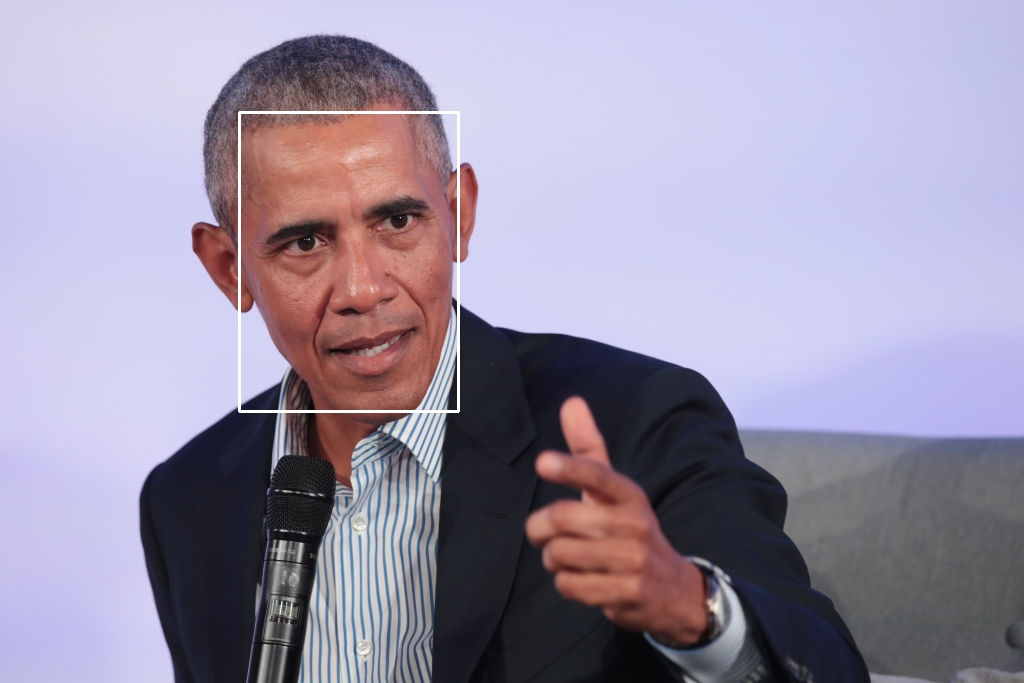

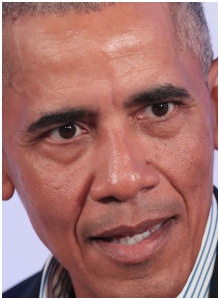

In [40]:
from IPython.display import Image
display(Image('updated_images/image.jpg'))
display(Image('faces/0_image.jpg'))